In [2]:
%load_ext autoreload
%autoreload 2

In [83]:
import numpy as np
from scipy.io.wavfile import read
import librosa
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import copy
import IPython.display

In [101]:
# http://www.findsounds.com/ISAPI/search.dll?start=51&keywords=jet&seed=23
IPython.display.Audio("./Lear.wav")

In [82]:
sr, signal = read('./Lear.wav')

In [6]:
sr

22050

In [37]:
signal = signal.astype(np.float)

In [39]:
stft = librosa.stft(signal, n_fft=512, hop_length=256)
sp = librosa.amplitude_to_db(np.abs(stft))

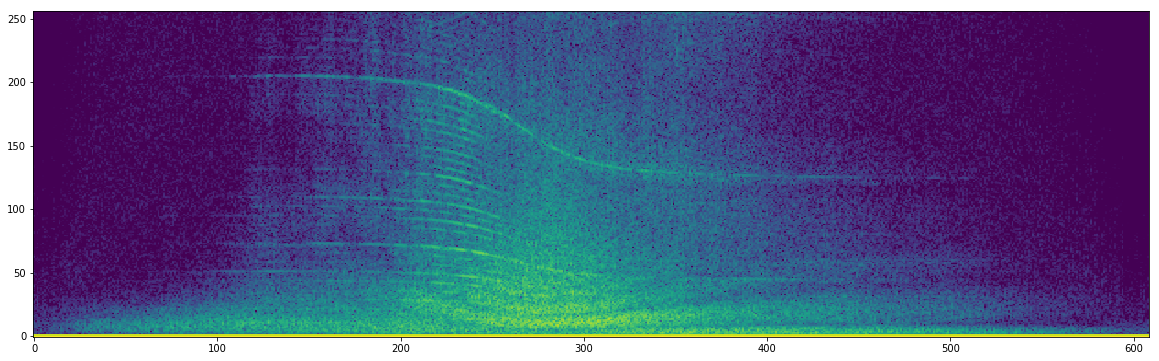

In [42]:
plt.figure(figsize=(20, 6))
plt.imshow(sp[:, :], aspect='auto', origin='lower')

In [63]:
clipped_sp = sp[:, 120:500]
clipped_sp = clipped_sp[:, ::-1]

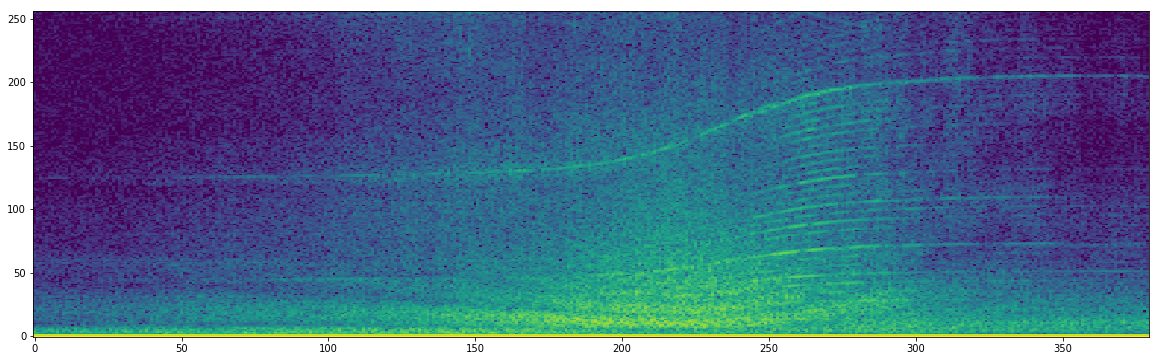

In [64]:
plt.figure(figsize=(20, 6))
plt.imshow(clipped_sp, aspect='auto', origin='lower')

In [65]:
clipped_sp.shape

(257, 380)

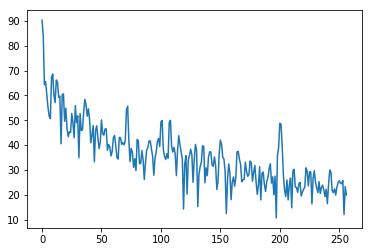

In [66]:
plt.plot(clipped_sp[:, 300])

In [67]:
clipped_sp = clipped_sp - clipped_sp.min(axis=0)
clipped_sp = (np.minimum(1, 0.03*np.maximum(0, np.linspace(0, 257, 257)))*clipped_sp.T).T
emission_probs = clipped_sp / clipped_sp.sum(axis=0)

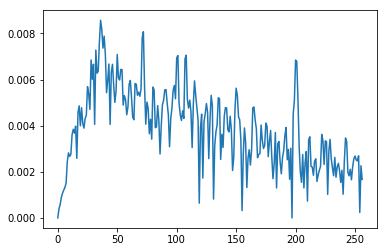

In [68]:
plt.plot(emission_probs[:, 300])

In [69]:
w = np.ones(5)/5.0
emission_probs = np.apply_along_axis(lambda m: np.convolve(m, w, mode='valid'), axis=1, arr=emission_probs)

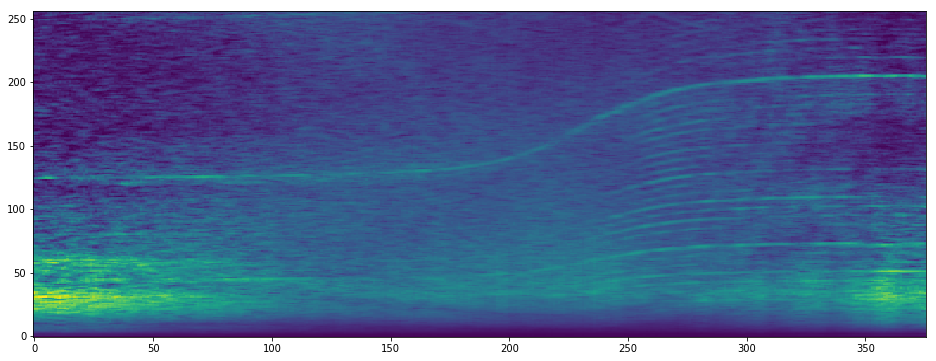

In [70]:
plt.figure(figsize=(16, 6))
plt.imshow(emission_probs, aspect='auto', origin='lower')

In [71]:
NUM_STATE = clipped_sp.shape[0]
print(NUM_STATE)

257


In [95]:
trans_probs = np.zeros([NUM_STATE, NUM_STATE])

SIGMA = 10.0 / NUM_STATE
COEFF = 1.0 / np.sqrt(2.0*np.pi*SIGMA**2)
print(COEFF)

for i in range(NUM_STATE):
    for j in range(NUM_STATE):
        freq_i = i / NUM_STATE
        freq_j = j / NUM_STATE
        trans_probs[i, j] = COEFF*np.exp(-((freq_i-freq_j)**2)/(2.0*SIGMA**2))

norms = trans_probs.sum(axis=1)
norms[norms == 0] = 1

trans_probs = (trans_probs.T/norms).T

10.25281660631682


In [96]:
STATES = [i for i in range(NUM_STATE)]

INIT_PROBS = np.ones(len(STATES)) #np.random.rand(len(STATES))
INIT_PROBS /= sum(INIT_PROBS)
INIT_PROBS = [p for state, p in zip(STATES, INIT_PROBS)]

In [97]:
t = 0
log_likelihoods = np.zeros(NUM_STATE)

for state in STATES:
    log_likelihoods[state] = np.log(INIT_PROBS[state]*emission_probs[state][t]+0.000000000000000001)

In [98]:
state_sequences = [[] for _ in range(NUM_STATE)]

for t in pb(range(1, emission_probs.shape[1]-1)):
    new_state_sequences = [[] for _ in range(NUM_STATE)]
    new_log_likelihoods = np.zeros(NUM_STATE)
    for next_state in range(NUM_STATE):
        cur_state_log_probs = np.log(np.exp(log_likelihoods) * emission_probs[:, t]*trans_probs[:, next_state] + 0.0000000001)
        cur_state = np.argmax(cur_state_log_probs)
        new_log_likelihoods[next_state] = np.max(cur_state_log_probs)
        new_state_sequences[next_state] = state_sequences[cur_state] + [next_state]
    state_sequences = copy.copy(new_state_sequences)
    log_likelihoods = copy.copy(new_log_likelihoods)

state_sequences = np.array(state_sequences)

#### SIGMA = 4.0 / NUM_STATE

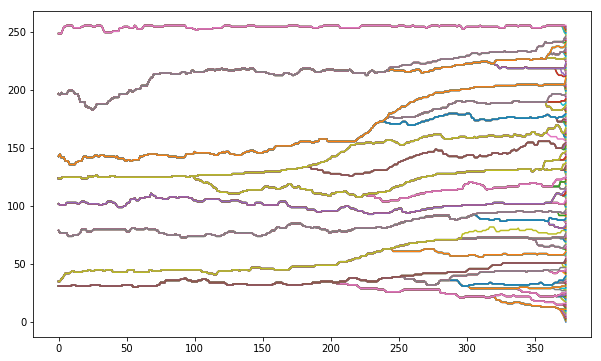

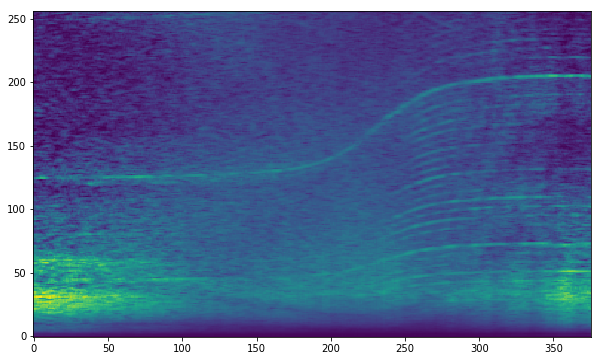

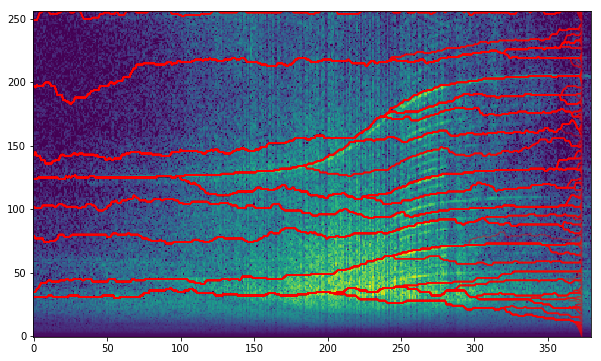

In [94]:
 plt.figure(figsize=(10, 6))

for i in range(NUM_STATE):
    plt.plot(state_sequences[i])

plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(emission_probs, aspect='auto', origin='lower')
plt.show()

plt.figure(figsize=(10, 6))

for i in range(NUM_STATE):
    plt.plot(state_sequences[i], alpha=0.4, c='red')

plt.imshow(clipped_sp, aspect='auto', origin='lower')
#plt.xlim(0, 3000)
plt.show()

#### SIGMA = 10.0 / NUM_STATE

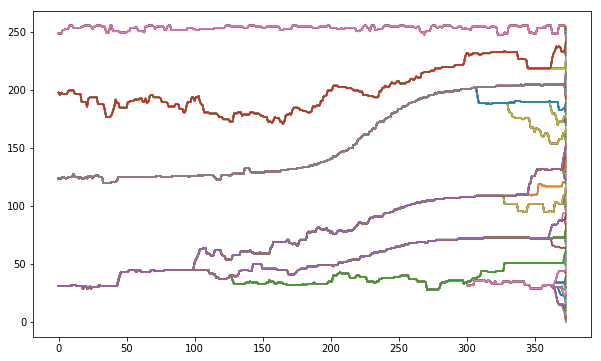

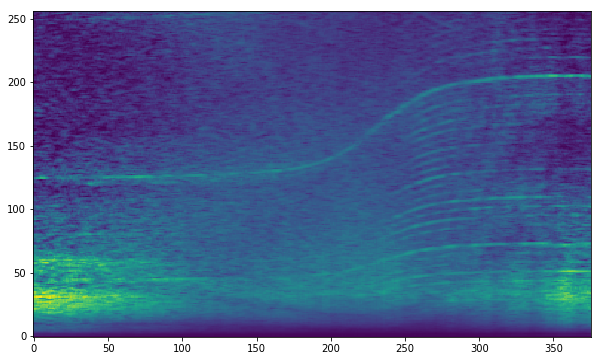

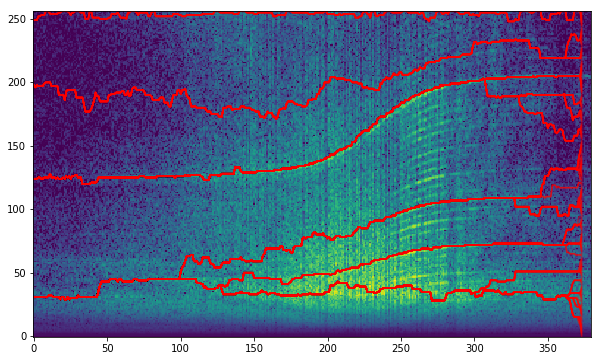

In [99]:
 plt.figure(figsize=(10, 6))

for i in range(NUM_STATE):
    plt.plot(state_sequences[i])

plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(emission_probs, aspect='auto', origin='lower')
plt.show()

plt.figure(figsize=(10, 6))

for i in range(NUM_STATE):
    plt.plot(state_sequences[i], alpha=0.4, c='red')

plt.imshow(clipped_sp, aspect='auto', origin='lower')
#plt.xlim(0, 3000)
plt.show()